# Environment Setup

In [6]:
import os
from scipy import ndimage, misc
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston, load_diabetes, load_digits, load_breast_cancer
from keras.datasets import mnist
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.datasets import make_regression
import statistics 

%matplotlib inline

# Help Method

In [7]:
def K_Fold(features, target, degree, numfolds, classifier):
    numfolds += 1
    kf = KFold(n_splits=numfolds)
    kf.get_n_splits(features)

    i = 0
    mae = np.zeros(numfolds-1)
    coef = np.zeros([numfolds-1, 16])
    for train_index, test_index in kf.split(features):
        features_train, features_test = features[train_index], features[test_index]
        target_train, target_test = target[train_index], target[test_index]
    
        poly = PolynomialFeatures(degree)
        features_poly_train = features_train 
        features_poly_test = features_test
        
        if classifier == "polynomial" :
            features_poly_train = poly.fit_transform(features_train)
            features_poly_test = poly.fit_transform(features_test)

        
        reg = LinearRegression().fit(features_poly_train, target_train)
        if classifier == "ridge" : 
            clf = Ridge(alpha=0.001)
            reg = clf.fit(features_poly_train, target_train)
        if classifier == "linear":
            if (i < numfolds - 1): 
                coef[i, :] = reg.coef_.reshape(1, 16)
        if classifier == "lasso":
            clf = linear_model.Lasso(alpha=0.1)
            reg = clf.fit(features_poly_train, target_train)
        if classifier == "huber":
            reg = HuberRegressor().fit(features_poly_train, target_train)
                
        i = i+1
        if (i < numfolds):
            mae[i-1] = mean_absolute_error(target_test, reg.predict(features_poly_test))
            
    avrmae = (sum(mae)/(numfolds-1))
    var = (statistics.variance(mae))
    return mae, avrmae, var, coef

In [8]:
def mv(coefmat):
    mean = np.zeros(coefmat.shape[1])
    var = np.zeros(coefmat.shape[1])
    for i in range(coefmat.shape[1]):
        mean[i] = np.mean(coefmat[:, i])
        var[i] = np.std(coefmat[:, i])
    return mean, var

# Data Read

In [9]:
target = pd.read_csv("extract_label_Jul08.csv", delimiter = ',')
target = target.as_matrix()
target = target[:,1]

features = pd.read_csv("extract_train_Jul08.csv", delimiter = ',')
features = features.as_matrix()
features = features[:, 1:17]

C:\Users\vn167\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\vn167\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


# Linear Regression

## Perform

In [95]:
reg = LinearRegression().fit(features, target)

print("The loss values is: ", mean_absolute_error(target, reg.predict(features)))

The loss values is:  2.110853811043013


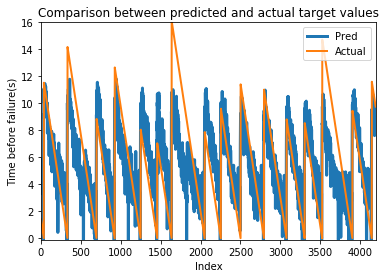

In [96]:
indx = range(target.shape[0])
plt.axis([0, target.shape[0], -0.1, 16])
plt.title("Comparison between predicted and actual target values")
plt.ylabel("Time before failure(s)")
plt.xlabel("Index")
plt.plot(indx, reg.predict(features), linewidth = 3, label = 'Pred')
plt.plot(indx, target, linewidth = 2, label = 'Actual')
plt.legend(loc='upper right')
plt.savefig('Linear Regression.png', dpi = 199)


#### Analysis

From the graph, we see that the linear regression model provide fairly acceptable prediction on the outcome - "Time before failure(s)". However, we can observe the tendency to center the values: the model can not predict high peak an show consistent trend of repeating height - nearly periodic. To combat this situation, we decided to use two different approaches: first is to use different type of regressor and compare and validate them using Kfold cross-validation, second is to use the polynomial regression. We suspect that there is no significant improvement when using different types of linear regression as all of them have a tendency to center the values.

## Compare different types of regression models

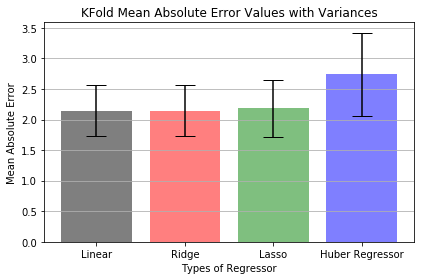

In [101]:
fl = ['Linear', 'Ridge', 'Lasso', 'Huber Regressor'] 
## coeff = reg.coef_.shape
materials = fl
x_pos = np.arange(len(fl))
t1, m, v, c = K_Fold(features,target,degree = 1, numfolds = 5, classifier = "linear")
t2, m1, v1, c1 = K_Fold(features,target,degree = 1, numfolds = 5, classifier = "ridge")
t3, m2, v2, c2 = K_Fold(features,target,degree = 1, numfolds = 5, classifier = "lasso")
t4, m3, v3, c3 = K_Fold(features,target,degree = 1, numfolds = 5, classifier = "huber")
tot = np.append(np.append(np.append(t1,t2), t3), t4)
mae = [m, m1, m2, m3]
var = [v, v1, v2, v3]
CTEs = mae
error = var
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', color = ['black', 'red', 'green', 'blue', 'cyan'], alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Mean Absolute Error')
ax.set_xlabel('Types of Regressor')
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('KFold Mean Absolute Error Values with Variances')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('Linear Regression K Fold.png', dpi = 199)
plt.show()

#### Analysis 
Just as what we predicted, using other types of regressor such as Ridge, Lasso, and Huber Regressor do not increase accuracy significantly. Specially, we event observe a worst model with Huber Regressor: higher Mean Absolute Error with higher variance

## Data Export

In [98]:
df = pd.DataFrame()
df['Types of Regressor'] = np.repeat(fl, 5)
df['Mean Absolute Error'] = tot
df.to_csv('Linear Regression Mean Absolute Error.csv')
df

,Types of Regressor,Mean Absolute Error
0,Linear,2.336975
1,Linear,1.996021
2,Linear,3.163791
3,Linear,1.726281
4,Linear,1.503667
5,Ridge,2.339548
6,Ridge,1.997280
7,Ridge,3.165231
8,Ridge,1.725023
9,Ridge,1.504624


## Feature Importance

We output and graphs the coefficients in the weight from linear regression model corresponding to features. This graphs will be able to tell us the gradient values of features and thus their respective importance.

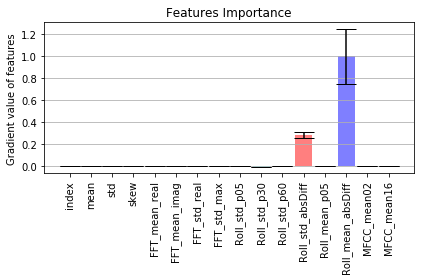

In [90]:
fl = ['index', 'mean', 'std', 'skew', 'FFT_mean_real', 'FFT_mean_imag', 
     'FFT_std_real', 'FFT_std_max', 'Roll_std_p05', 'Roll_std_p30', 
      'Roll_std_p60', 'Roll_std_absDiff', 'Roll_mean_p05', 
      'Roll_mean_absDiff', 'MFCC_mean02', 'MFCC_mean16']
t, m, v, c = K_Fold(features,target, degree = 1, numfolds = 5, classifier = "linear")
mean, error = mv(c)
## coeff = reg.coef_.shape
materials = fl
x_pos = np.arange(len(fl))
CTEs = -mean/ np.amax(-mean)
error = error/ np.amax(-mean)
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', color = ['black', 'red', 'green', 'blue', 'cyan'], alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Gradient value of features')
ax.set_xticks(x_pos)
ax.set_xticklabels(materials, rotation = 'vertical')
ax.set_title('Features Importance')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png', dpi = 199)
plt.show()

## Data Export

In [91]:
df = pd.DataFrame()
df['features'] = fl
df['importance'] = np.abs(mean)/(np.max(np.abs(mean)))
df.to_csv('LinearRegressionImportance_export.csv')
df

,features,importance
0,index,5.617223e-08
1,mean,3.726905e-04
2,std,3.768426e-05
3,skew,3.554372e-05
4,FFT_mean_real,4.738972e-08
5,FFT_mean_imag,1.509208e-11
6,FFT_std_real,1.270447e-07
7,FFT_std_max,1.018107e-09
8,Roll_std_p05,5.306443e-03
9,Roll_std_p30,1.957655e-03


# Polynomial Regression

## Perform KFold to analyze and determine optimal degree

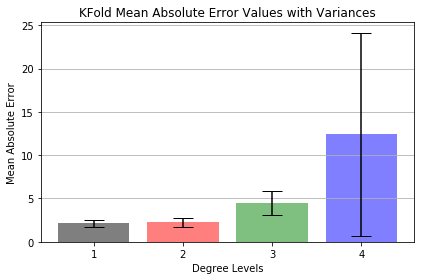

In [125]:
fl = ['1','2','3','4'] 
i = np.array([1,2,3,4])
## coeff = reg.coef_.shape
materials = fl
x_pos = np.arange(len(fl))
tot = np.zeros(1)
mae = np.zeros(i.shape[0])
var = np.zeros(i.shape[0])
for numfold in range(i.shape[0]):
    t, m, v, c = K_Fold(features,target, degree = i[numfold], numfolds = 5, classifier = "polynomial")
    mae[numfold] = m
    var[numfold] = v
    tot = np.append(tot, t, axis = 0)
CTEs = mae
error = var
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', color = ['black', 'red', 'green', 'blue', 'cyan'], alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Mean Absolute Error')
ax.set_xlabel('Degree Levels')
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('KFold Mean Absolute Error Values with Variances')
ax.yaxis.grid(True)
tot = np.delete(tot, 0)
# Save the figure and show
plt.tight_layout()
plt.savefig('Polynomial K Fold.png', dpi = 199)
plt.show()

### Analysis
From the graph, we can observe that the Mean Absolute Error has a tendency to increase with degree levels. Furthermore, the variance also increases significantly which implies that we mau overfit the data with higher order models. Since degree equals 1 is the Linear Regression model, we decide to use degree of 2 to continue our analysis.

## Perform Polynomial Regreesion with Degree of 2

In [100]:
poly = PolynomialFeatures(degree=2)
features_poly = poly.fit_transform(features)
reg = LinearRegression().fit(features_poly, target)

print("The loss values is: ", mean_absolute_error(target, reg.predict(features_poly)))


The loss values is:  1.985654086901071


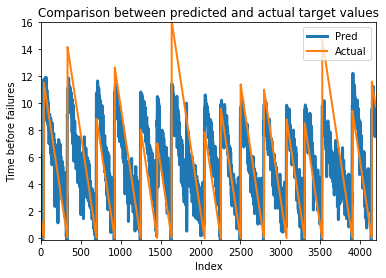

In [31]:
indx = range(target.shape[0])
plt.axis([0, target.shape[0], -0.1, 16])
plt.title("Comparison between predicted and actual target values")
plt.ylabel("Time before failures")
plt.xlabel("Index")
plt.plot(indx, reg.predict(features_poly), linewidth = 3, label = 'Pred')
plt.plot(indx, target, linewidth = 2, label = 'Actual')
plt.legend(loc='upper right')
plt.savefig('Polynomial Regression.png', dpi = 199)


## Data Export

In [62]:
df = pd.DataFrame()
df['Degree'] = np.repeat(fl, 5)
df['Mean Absolute Error'] = tot
df.to_csv('Polynomial Regression Mean Absolute Error.csv')
df

,Degree,Mean Absolute Error
0,1,2.336975
1,1,1.996021
2,1,3.163791
3,1,1.726281
4,1,1.503667
5,2,2.431142
6,2,2.011570
7,2,3.420865
8,2,1.836903
9,2,1.558376


# Comparision Between Linear and Polynomial Regression

## Compare the Mean Absolute Error 

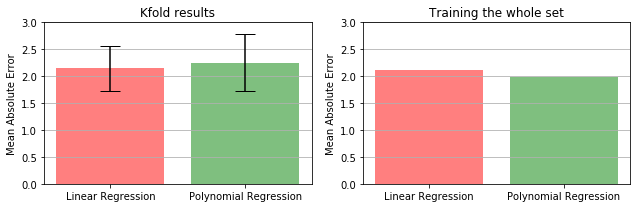

In [118]:
fl = ['Linear Regression', 'Polynomial Regression']
t1, m1, v1, c1 = K_Fold(features,target, degree = 1, numfolds = 5, classifier = "linear")
t2, m2, v2, c2 = K_Fold(features,target, degree = 2, numfolds = 5, classifier = "polynomial")
mae = np.append(m1, m2)
var = np.append(v1,v2)
## coeff = reg.coef_.shape
materials = fl
x_pos = np.arange(len(fl))
CTEs = mae
error = var
# Build the plot
fig, ax = plt.subplots(1,2,figsize =(9,3))
ax[0].bar(x_pos, CTEs, yerr=error, align='center', color = ['red', 'green'], alpha=0.5, ecolor='black', capsize=10)
ax[0].set_ylim(0, 3)
ax[0].set_ylabel('Mean Absolute Error')
ax[0].set_xticks(x_pos)
ax[0].set_xticklabels(materials)
ax[0].set_title('Kfold results')
ax[0].yaxis.grid(True)

CTEs = [2.110853811043013, 1.985654086901071]

ax[1].bar(x_pos, CTEs, align='center', color = ['red', 'green'], alpha=0.5, ecolor='black', capsize=10)
ax[1].set_ylim(0, 3)
ax[1].set_ylabel('Mean Absolute Error')
ax[1].set_xticks(x_pos)
ax[1].set_xticklabels(materials)
ax[1].set_title('Training the whole set')
ax[1].yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('Compare MAE Linear Polynomial.png', dpi = 199)
plt.show()

## Compare the Prediction Results

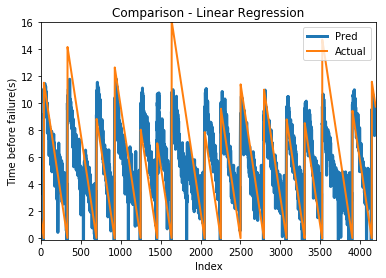

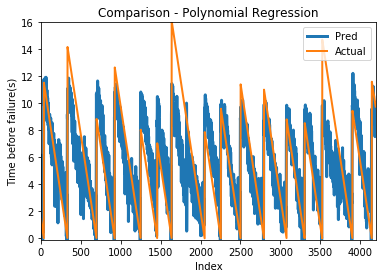

In [124]:
reg = LinearRegression().fit(features, target)

indx = range(target.shape[0])
plt.axis([0, target.shape[0], -0.1, 16])
plt.title("Comparison - Linear Regression")
plt.ylabel("Time before failure(s)")
plt.xlabel("Index")
plt.plot(indx, reg.predict(features), linewidth = 3, label = 'Pred')
plt.plot(indx, target, linewidth = 2, label = 'Actual')
plt.legend(loc='upper right')
plt.savefig('Compare P Linear.png', dpi = 324)
plt.show()

poly = PolynomialFeatures(degree=2)
features_poly = poly.fit_transform(features)
reg = LinearRegression().fit(features_poly, target)

indx = range(target.shape[0])
plt.axis([0, target.shape[0], -0.1, 16])
plt.title("Comparison - Polynomial Regression")
plt.ylabel("Time before failure(s)")
plt.xlabel("Index")
plt.plot(indx, reg.predict(features_poly), linewidth = 3, label = 'Pred')
plt.plot(indx, target, linewidth = 2, label = 'Actual')
plt.legend(loc='upper right')
plt.savefig('Compare P Polynomial.png', dpi = 324)
plt.show()